## 台股外資 10 20 60 天 趨勢線 ＆ 月季線趨勢

Populating the interactive namespace from numpy and matplotlib
波動度太差, 會非常不利長線出手！！！


,收盤,漲跌差,盤勢,波動,趨勢,漲跌5,速度,月線,季線,DIF,大盤,外資10,外資20,外資60,外資,10日上,10日下,20日上,20日下,個股K線
88,10691.0,-11.64,-,391.35,-,-319.00,動,-1,-1,-1,空,-104.51,27.73,-1115.42,-,27,69,35,62,空
89,10699.0,0.29,-,344.17,-,-240.63,動,-1,-1,-1,空,-50.60,-1.98,-1069.90,-,27,69,35,62,空
90,10792.0,95.19,順,299.78,-,-5.75,-,-1,-1,-1,空,30.85,56.66,-1026.37,-,36,63,33,64,空
91,10804.0,13.96,-,140.33,盤,-23.08,-,-1,-1,1,-,-76.64,54.28,-987.58,-,20,50,27,59,空
92,10863.0,45.80,順,179.23,盤,199.56,動,-1,1,1,-,-37.54,58.05,-800.59,-,40,56,41,57,-
93,10809.0,-56.56,順,179.23,盤,106.75,動,-1,-1,1,-,-34.08,-34.73,-794.59,-,34,58,37,62,-
94,10902.0,55.04,順,218.31,-,203.45,動,-1,-1,1,-,87.30,49.57,-725.29,-,62,37,42,57,-
95,10990.0,43.22,順,298.59,-,292.54,動,-1,-1,1,-,172.74,130.78,-720.99,多,64,33,45,52,多
96,11100.0,70.45,順,400.52,-,309.33,動,1,-1,1,多,340.80,253.20,-609.59,多,79,20,44,51,多
97,11094.0,-60.22,順,307.37,-,276.42,動,1,-1,1,多,368.17,339.57,-686.90,多,77,19,54,44,多


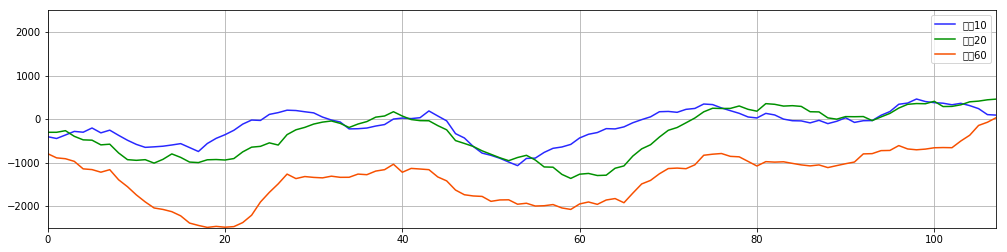

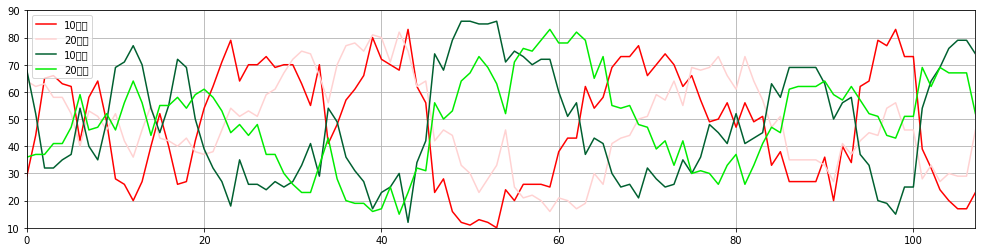

In [41]:
%pylab inline
from colorama import Fore
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sheetName = 'tw100' # 台灣100
df = pd.read_excel('files/data.xlsx', sheetname=sheetName)
# 外資買賣超
df1 = df[['外資10','外資20','外資60']]
df1.plot(ylim=(-2500,2500),linestyle='-',kind='line',figsize=(17,4),color=['#2828FF','#009100','#F75000'],grid=True) 
# TW100趨勢
df2 = df[['10日上','20日上','10日下','20日下']]
df2.plot(ylim=(10,90),linestyle='-',kind='line',figsize=(17,4),color=['#ff0000','#ffd2d2','#006030','#00ec00'],grid=True) 

# 盤勢分析
# 1. 趨勢：開盤收盤超過40點 => 趨勢盤
# 2. 波動：計算過去8天最高和最低差 (波動越小, 就越困難操作)
df['收盤'] = round(df['CLOSE'])
df['漲跌差'] = df['CLOSE'] - df['OPEN']
conditions = [
    (df['OPEN'] - df['CLOSE'] > 40),
    (df['OPEN'] - df['CLOSE'] < -40)]
choices = ['順', '順']
df['盤勢'] = np.select(conditions, choices, default='-')
df['波動'] = df['HIGH8D'] - df['LOW8D']
df['趨勢'] = np.where(df['波動'] < 180, '盤', '-')

# 大盤多空分析：
# 1. 大盤月線 + 大盤DIF(先不考慮季線)
# 1.1. 月上DIF上 => 多; 
# 1.2. 月上DIF下 => 盤;
# 1.3. 月下DIF上 => 盤;
# 1.4. 月下DIF下 => 空;
conditions = [
    (df['月線'] + df['DIF'] == 2),
    (df['月線'] + df['DIF'] == -2)]
choices = ['多', '空']
df['大盤'] = np.select(conditions, choices, default='-')

# 2. 外資籌碼
# 2.1. 10日正20日正 => 多
# 2.2. 10日正20日負 => 盤
# 2.3. 10日負20日正 => 盤
# 2.4. 10日負20日負 => 空
conditions = [
    (df['外資10'] + df['外資20'] > 300),
    (df['外資10'] + df['外資20'] < -300)]
choices = ['多', '空']
df['外資'] = np.select(conditions, choices, default='-')

# 3. 個股K線
# 3.1. TW100差 大於  25  => 多
# 3.2. TW100差 小於 -25  => 空
# 3.3. TW100差 介於 之間 => 盤 
df['TW100差'] = df['10日上'] - df['10日下']
conditions = [
    (df['10日上'] - df['10日下'] > 25),
    (df['10日上'] - df['10日下'] < -25)]
choices = ['多', '空']
df['個股K線'] = np.select(conditions, choices, default='-')

# 4. 漲跌5
# 4.1. 小於-100 or 大於100 => 動
conditions = [
    (df['漲跌5'] > 100),
    (df['漲跌5'] < -100)]
choices = ['動', '動']
df['速度'] = np.select(conditions, choices, default='-')

print(Fore.RED+'波動度太差, 會非常不利長線出手！！！')
df[['收盤','漲跌差','盤勢','波動','趨勢','漲跌5','速度','月線','季線','DIF','大盤','外資10','外資20','外資60','外資','10日上','10日下','20日上','20日下','個股K線']].tail(20)


## 期貨-每月期望值統計資料

In [42]:
import pandas as pd
import numpy as np
from colorama import Fore

sheetName = 'all' # 交易資料 by 年份

dates=['2018-12','2018-11','2018-10','2018-9','2018-8','2018-7',\
       '2018-6','2018-5','2018-4','2018-3','2018-2','2018-1', \
       '2017-12','2017-11','2017-10']

#dates=['2017-12','2017-11','2017-10']

df = pd.read_excel('files/data.xlsx', sheetname=sheetName)

df['Date'] = df['成交時間'].dt.year.astype(str)+'-'+df['成交時間'].dt.month.astype(str)
df['Lot'] = df['口數']
df['Balance'] = df['平倉損益']

df = df[['Date','Lot','Balance']]

datas = []
for date in reversed(dates):
    df1 = df[df['Date']==date]
    if not df1.empty:
        obj = {}
        obj['年月份'] = date
        obj['虧損口數'] = df1[df1['Balance']<0]['Lot'].sum()
        obj['獲利口數'] = df1[df1['Balance']>=0]['Lot'].sum()
        obj['總口數'] = df1['Lot'].sum()
        obj['勝率%'] = str(round((obj['獲利口數'] / obj['總口數'])*100, 1))+'%'
        obj['總虧損'] = df1[df1['Balance']<0]['Balance'].sum()
        obj['總獲利'] = df1[df1['Balance']>=0]['Balance'].sum()
        obj['淨利'] = df1['Balance'].sum()
        obj['期望報酬'] = round((obj['淨利'] / obj['總口數']))
        obj['平均虧損'] = round(obj['總虧損'] / obj['虧損口數'],0)
        obj['平均獲利'] = round(obj['總獲利'] / obj['獲利口數'],0)
        obj['盈虧比'] = str(round((obj['平均獲利'] / obj['平均虧損'] * -1),2))+':1'
        obj['最大虧損'] = df1['Balance'].min()
        obj['最大獲利'] = df1['Balance'].max()
        obj['品質A'] = round((obj['平均獲利'] / obj['平均虧損'] * -1) - (obj['虧損口數'] / obj['獲利口數']),2)
        obj['品質B'] = str(round(100*((obj['獲利口數'] / obj['總口數']) * (obj['平均獲利'] / obj['平均虧損'] * -1) - (1 - (obj['獲利口數'] / obj['總口數']))),1))+'%'
         
        # 計算淨利成長率   
        if(len(datas) != 0):
            total = 0 
            for month in range(0, len(datas)):
                total = total + datas[month]['淨利']
            obj['淨成長率'] = str(round((obj['淨利'] / total)*100, 1))+'%'
            
        datas.append(obj)

# Total        
obj ={}
obj['年月份'] = 'Total'
obj['虧損口數'] = df[df['Balance']<0]['Lot'].sum()
obj['獲利口數'] = df[df['Balance']>=0]['Lot'].sum()
obj['總口數'] = df['Lot'].sum()
obj['勝率%'] = str(round((obj['獲利口數'] / obj['總口數'])*100, 1))+'%'
obj['總虧損'] = df[df['Balance']<0]['Balance'].sum()
obj['總獲利'] = df[df['Balance']>=0]['Balance'].sum()
obj['淨利'] = df['Balance'].sum()
obj['期望報酬'] = round((obj['淨利'] / obj['總口數']))
obj['平均虧損'] = round(obj['總虧損'] / obj['虧損口數'],0)
obj['平均獲利'] = round(obj['總獲利'] / obj['獲利口數'],0)
obj['盈虧比'] = str(round((obj['平均獲利'] / obj['平均虧損'] * -1),2))+':1'
obj['最大虧損'] = df['Balance'].min()
obj['最大獲利'] = df['Balance'].max()
obj['品質A'] = round((obj['平均獲利'] / obj['平均虧損'] * -1) - (obj['虧損口數'] / obj['獲利口數']),2)
obj['品質B'] = str(round(100*((obj['獲利口數'] / obj['總口數']) * (obj['平均獲利'] / obj['平均虧損'] * -1) - (1 - (obj['獲利口數'] / obj['總口數']))),1))+'%'
datas.insert(0,obj)
       
df = pd.DataFrame(datas).sort_index(ascending=False)

print(Fore.RED+'交易聖經：接受最大逆境; 市場該做的事就是讓大多數的人失望！永遠不要覺得好像容易了...')

df[['年月份','虧損口數','獲利口數','總口數','勝率%','總虧損','總獲利','淨利','淨成長率','期望報酬','平均虧損','平均獲利','盈虧比','最大虧損','最大獲利','品質A','品質B']]

# 交易系統關鍵：正期望值 * 交易機會 * 部位大小(破產風險)
# 交易品質A：大於1表示完美; 1~0.75表示不錯; 0.75~0.5表示可用稍不足; 低於0.5表示其實不及格
# 交易品質B：勝率50%+盈虧比3:1表示100%期望值(完美); 勝率50%+盈虧比2:1表示50%期望值; 品質至少要維持33%以上
# 交易目標：維持勝率43%左右; 盈虧比2:1以上;

交易聖經：接受最大逆境; 市場該做的事就是讓大多數的人失望！永遠不要覺得好像容易了...


,年月份,虧損口數,獲利口數,總口數,勝率%,總虧損,總獲利,淨利,淨成長率,期望報酬,平均虧損,平均獲利,盈虧比,最大虧損,最大獲利,品質A,品質B
12,2018-9,42,19,61,31.1%,-25790,119312,93522,31.5%,1533.0,-614.0,6280.0,10.23:1,-4928,43384,8.02,249.7%
11,2018-8,70,55,125,44.0%,-67150,96780,29630,11.1%,237.0,-959.0,1760.0,1.84:1,-11520,43822,0.56,24.8%
10,2018-7,25,24,49,49.0%,-36046,194102,158056,145.3%,3226.0,-1442.0,8088.0,5.61:1,-13962,80530,4.57,223.7%
9,2018-6,69,34,103,33.0%,-62417,64110,1693,1.6%,16.0,-905.0,1886.0,2.08:1,-7262,16938,0.05,1.8%
8,2018-5,40,28,68,41.2%,-43036,51496,8460,8.6%,124.0,-1076.0,1839.0,1.71:1,-6262,14936,0.28,11.6%
7,2018-4,55,20,75,26.7%,-100918,86312,-14606,-12.9%,-195.0,-1835.0,4316.0,2.35:1,-18000,30936,-0.40,-10.6%
6,2018-3,74,64,138,46.4%,-87646,123864,36218,47.0%,262.0,-1184.0,1935.0,1.63:1,-10896,23092,0.48,22.2%
5,2018-2,22,20,42,47.6%,-33177,74996,41819,118.8%,996.0,-1508.0,3750.0,2.49:1,-7314,17940,1.39,66.0%
4,2018-1,11,14,25,56.0%,-8024,35080,27056,332.5%,1082.0,-729.0,2506.0,3.44:1,-3264,11218,2.65,148.5%
3,2017-12,9,11,20,55.0%,-14128,13961,-167,-2.0%,-8.0,-1570.0,1269.0,0.81:1,-4481,7019,-0.01,-0.5%


## 部位規模控制 - 固定百分率
#### 固定百分率 - 專業交易員最常用
#### 公式：合約口數 = (固定百分率 * 帳戶餘額) / 個別交易風險
#### 個別交易風險: 近三個月平均虧損的平均

In [43]:
positionSize = 0
固定百分率 = 0.017 # 帳戶規模越大要降低風險最佳1-2%
帳戶餘額 = obj['淨利']
for i in range(7,2,-1):
    個別交易風險 = abs((datas[-2]['平均虧損'] + datas[-3]['平均虧損'] + datas[-4]['平均虧損']) / 3) * i
    if(positionSize == 0 and round((固定百分率 * 帳戶餘額) / 個別交易風險,2) > 1):
        positionSize = i
    print('Lot:',i, '部位門檻:',round((固定百分率 * 帳戶餘額) / 個別交易風險,2))
    
print('計算可交易部位：',positionSize)

Lot: 7 部位門檻: 0.86
Lot: 6 部位門檻: 1.0
Lot: 5 部位門檻: 1.2
Lot: 4 部位門檻: 1.5
Lot: 3 部位門檻: 2.01
計算可交易部位： 5


## 破產風險 ＆ 期望報酬(R)
#### 破產風險 = 虧損機率 ** ( ( 淨利  x  0.1 ) / ( 平均虧損 x 部位規模 ) ) ---- 破產定義：淨利減少1成就算破產!! XD
#### 單筆虧損(%) 建議要低於 2%, 1.5%更佳; 長期甚至低於1%
#### 破產風險(%) 建議要降為 0%

In [44]:
print('部位規模    : '+str(positionSize))  # 部位規模
print('目前淨利    : '+str('${:,.0f}'.format(obj['淨利'])))
print('單筆虧損(%) : '+str(round(abs((obj['平均虧損'] * positionSize) / obj['淨利']),3) * 100)+'%')
print('平均虧損    : '+str(round(obj['總虧損'] / obj['虧損口數'],0)))
print('破產風險    : '+str(round((obj['虧損口數'] / obj['總口數']) ** abs((obj['淨利']*0.1) / (obj['平均虧損'] * (positionSize))) * 100, 2))+'%')
print('期望報酬(R) : '+str(round((obj['期望報酬'] / obj['平均虧損']) * -1,2))+'R')
print('實現報酬(R) : '+str(round((obj['期望報酬'] / obj['平均虧損']) * -1,2) * obj['總口數'] )+'R')
print('=========================')
print('淨利七成    : '+str(round((obj['虧損口數'] / obj['總口數']) ** abs((obj['淨利']*0.3) / (obj['平均虧損'] * (positionSize))) * 100, 2))+'%')
print('淨利減半    : '+str(round((obj['虧損口數'] / obj['總口數']) ** abs((obj['淨利']*0.5) / (obj['平均虧損'] * (positionSize))) * 100, 2))+'%')
base = 0.1         # 淨成長率
target = 10000000  # 淨目標 1,000w
profit = obj['淨利']
for i in range(1,50):
    profit = profit * (1 + base)
    if(profit > target):
        print('淨利目標    : '+str('${:,.0f}'.format(target)))
        print('預估期數    : '+str(i))
        break

部位規模    : 5
目前淨利    : $389,986
單筆虧損(%) : 1.5%
平均虧損    : -1151.0
破產風險    : 2.74%
期望報酬(R) : 0.46R
實現報酬(R) : 336.26R
淨利七成    : 0.0%
淨利減半    : 0.0%
淨利目標    : $10,000,000
預估期數    : 35


In [45]:
### 這需要的是一個完整的章節, 

## 每月交易統計紀錄

In [46]:
import pandas as pd
import numpy as np


df = pd.read_excel('files/data.xlsx', sheetname=sheetName)

df['Date'] = df['成交時間'].dt.year.astype(str)+'-'+df['成交時間'].dt.month.astype(str)
df['Lot'] = df['口數']
df['Balance'] = df['平倉損益']

df = df[['Date','Lot','Balance']]

datas = []
for date in reversed(dates):
    df1 = df[df['Date']==date]
    if not df1.empty:
        obj = {}
        obj['年月份'] = date
        obj['-150~90'] = df1[(df1['Balance']/df1['Lot'] >= -7500) & (df1['Balance']/df1['Lot'] < -4500)]['Lot'].sum()
        obj['-90~60'] = df1[(df1['Balance']/df1['Lot'] >= -4500) & (df1['Balance']/df1['Lot'] < -3000)]['Lot'].sum()
        obj['-60~45'] = df1[(df1['Balance']/df1['Lot'] >= -3000) & (df1['Balance']/df1['Lot'] < -2250)]['Lot'].sum()
        obj['-45~30'] = df1[(df1['Balance']/df1['Lot'] >= -2250) & (df1['Balance']/df1['Lot'] < -1500)]['Lot'].sum()
        obj['-30~15'] = df1[(df1['Balance']/df1['Lot'] >= -1500) & (df1['Balance']/df1['Lot'] < -750)]['Lot'].sum()
        obj['-15~0'] = df1[(df1['Balance']/df1['Lot'] >= -750) & (df1['Balance']/df1['Lot'] < 0)]['Lot'].sum()
        obj['0~15'] = df1[(df1['Balance']/df1['Lot'] >= 0) & (df1['Balance']/df1['Lot'] < 750)]['Lot'].sum()
        obj['15~30'] = df1[(df1['Balance']/df1['Lot'] >= 750) & (df1['Balance']/df1['Lot'] < 1500)]['Lot'].sum()
        obj['30~45'] = df1[(df1['Balance']/df1['Lot'] >= 1500) & (df1['Balance']/df1['Lot'] < 2250)]['Lot'].sum()
        obj['45~60'] = df1[(df1['Balance']/df1['Lot'] >= 2250) & (df1['Balance']/df1['Lot'] < 3000)]['Lot'].sum()
        obj['60~90'] = df1[(df1['Balance']/df1['Lot'] >= 3000) & (df1['Balance']/df1['Lot'] < 4500)]['Lot'].sum()
        obj['90~120'] = df1[(df1['Balance']/df1['Lot'] >= 4500) & (df1['Balance']/df1['Lot'] < 6000)]['Lot'].sum()
        obj['120~150'] = df1[(df1['Balance']/df1['Lot'] >= 6000) & (df1['Balance']/df1['Lot'] < 7500)]['Lot'].sum()
        obj['150~180'] = df1[(df1['Balance']/df1['Lot'] >= 7500) & (df1['Balance']/df1['Lot'] < 9000)]['Lot'].sum()
        obj['180~210'] = df1[(df1['Balance']/df1['Lot'] >= 9000) & (df1['Balance']/df1['Lot'] < 10500)]['Lot'].sum()
        obj['210~240'] = df1[(df1['Balance']/df1['Lot'] >= 10500) & (df1['Balance']/df1['Lot'] < 12000)]['Lot'].sum()
        obj['240~500'] = df1[(df1['Balance']/df1['Lot'] >= 12000) & (df1['Balance']/df1['Lot'] < 25000)]['Lot'].sum()
        datas.append(obj)

# Lot Sum
obj = {}
obj['年月份'] = 'Total'
obj['-150~90'] = df[(df['Balance']/df['Lot'] >= -7500) & (df['Balance']/df['Lot'] < -4500)]['Lot'].sum()
obj['-90~60'] = df[(df['Balance']/df['Lot'] >= -4500) & (df['Balance']/df['Lot'] < -3000)]['Lot'].sum()
obj['-60~45'] = df[(df['Balance']/df['Lot'] >= -3000) & (df['Balance']/df['Lot'] < -2250)]['Lot'].sum()
obj['-45~30'] = df[(df['Balance']/df['Lot'] >= -2250) & (df['Balance']/df['Lot'] < -1500)]['Lot'].sum()
obj['-30~15'] = df[(df['Balance']/df['Lot'] >= -1500) & (df['Balance']/df['Lot'] < -750)]['Lot'].sum()
obj['-15~0'] = df[(df['Balance']/df['Lot'] >= -750) & (df['Balance']/df['Lot'] < 0)]['Lot'].sum()
obj['0~15'] = df[(df['Balance']/df['Lot'] >= 0) & (df['Balance']/df['Lot'] < 750)]['Lot'].sum()
obj['15~30'] = df[(df['Balance']/df['Lot'] >= 750) & (df['Balance']/df['Lot'] < 1500)]['Lot'].sum()
obj['30~45'] = df[(df['Balance']/df['Lot'] >= 1500) & (df['Balance']/df['Lot'] < 2250)]['Lot'].sum()
obj['45~60'] = df[(df['Balance']/df['Lot'] >= 2250) & (df['Balance']/df['Lot'] < 3000)]['Lot'].sum()
obj['60~90'] = df[(df['Balance']/df['Lot'] >= 3000) & (df['Balance']/df['Lot'] < 4500)]['Lot'].sum()
obj['90~120'] = df[(df['Balance']/df['Lot'] >= 4500) & (df['Balance']/df['Lot'] < 6000)]['Lot'].sum()
obj['120~150'] = df[(df['Balance']/df['Lot'] >= 6000) & (df['Balance']/df['Lot'] < 7500)]['Lot'].sum()
obj['150~180'] = df[(df['Balance']/df['Lot'] >= 7500) & (df['Balance']/df['Lot'] < 9000)]['Lot'].sum()
obj['180~210'] = df[(df['Balance']/df['Lot'] >= 9000) & (df['Balance']/df['Lot'] < 10500)]['Lot'].sum()
obj['210~240'] = df[(df['Balance']/df['Lot'] >= 10500) & (df['Balance']/df['Lot'] < 12000)]['Lot'].sum()
obj['240~500'] = df[(df['Balance']/df['Lot'] >= 12000) & (df['Balance']/df['Lot'] < 25000)]['Lot'].sum()
datas.insert(0,obj)

# Balance Sum
obj = {}
obj['年月份'] = '損益金額'
obj['-150~90'] = df[(df['Balance']/df['Lot'] >= -7500) & (df['Balance']/df['Lot'] < -4500)]['Balance'].sum()
obj['-90~60'] = df[(df['Balance']/df['Lot'] >= -4500) & (df['Balance']/df['Lot'] < -3000)]['Balance'].sum()
obj['-60~45'] = df[(df['Balance']/df['Lot'] >= -3000) & (df['Balance']/df['Lot'] < -2250)]['Balance'].sum()
obj['-45~30'] = df[(df['Balance']/df['Lot'] >= -2250) & (df['Balance']/df['Lot'] < -1500)]['Balance'].sum()
obj['-30~15'] = df[(df['Balance']/df['Lot'] >= -1500) & (df['Balance']/df['Lot'] < -750)]['Balance'].sum()
obj['-15~0'] = df[(df['Balance']/df['Lot'] >= -750) & (df['Balance']/df['Lot'] < 0)]['Balance'].sum()
obj['0~15'] = df[(df['Balance']/df['Lot'] >= 0) & (df['Balance']/df['Lot'] < 750)]['Balance'].sum()
obj['15~30'] = df[(df['Balance']/df['Lot'] >= 750) & (df['Balance']/df['Lot'] < 1500)]['Balance'].sum()
obj['30~45'] = df[(df['Balance']/df['Lot'] >= 1500) & (df['Balance']/df['Lot'] < 2250)]['Balance'].sum()
obj['45~60'] = df[(df['Balance']/df['Lot'] >= 2250) & (df['Balance']/df['Lot'] < 3000)]['Balance'].sum()
obj['60~90'] = df[(df['Balance']/df['Lot'] >= 3000) & (df['Balance']/df['Lot'] < 4500)]['Balance'].sum()
obj['90~120'] = df[(df['Balance']/df['Lot'] >= 4500) & (df['Balance']/df['Lot'] < 6000)]['Balance'].sum()
obj['120~150'] = df[(df['Balance']/df['Lot'] >= 6000) & (df['Balance']/df['Lot'] < 7500)]['Balance'].sum()
obj['150~180'] = df[(df['Balance']/df['Lot'] >= 7500) & (df['Balance']/df['Lot'] < 9000)]['Balance'].sum()
obj['180~210'] = df[(df['Balance']/df['Lot'] >= 9000) & (df['Balance']/df['Lot'] < 10500)]['Balance'].sum()
obj['210~240'] = df[(df['Balance']/df['Lot'] >= 10500) & (df['Balance']/df['Lot'] < 12000)]['Balance'].sum()
obj['240~500'] = df[(df['Balance']/df['Lot'] >= 12000) & (df['Balance']/df['Lot'] < 25000)]['Balance'].sum()
datas.insert(0,obj)

        
df = pd.DataFrame(datas).sort_index(ascending=False)
df = df[['年月份','-150~90','-90~60','-60~45','-45~30','-30~15','-15~0','0~15','15~30','30~45','45~60','60~90', \
         '90~120','120~150','150~180','180~210','210~240','240~500']]

df

,年月份,-150~90,-90~60,-60~45,-45~30,-30~15,-15~0,0~15,15~30,30~45,45~60,60~90,90~120,120~150,150~180,180~210,210~240,240~500
13,2018-9,0,0,0,0,16,26,4,0,0,0,5,0,0,4,0,6,0
12,2018-8,0,3,5,11,12,39,37,6,0,0,4,4,0,0,0,4,0
11,2018-7,3,0,0,9,3,10,2,5,0,0,3,0,0,0,4,5,5
10,2018-6,0,0,3,10,19,37,16,2,2,7,2,5,0,0,0,0,0
9,2018-5,0,2,2,8,6,22,18,4,0,0,2,0,4,0,0,0,0
8,2018-4,6,3,6,8,14,18,11,0,0,0,3,0,0,0,2,2,2
7,2018-3,4,3,5,7,17,38,30,11,8,5,3,2,0,2,0,3,0
6,2018-2,0,4,0,4,9,5,7,2,1,2,0,2,1,4,1,0,0
5,2018-1,0,0,0,2,2,7,7,2,0,1,2,0,0,0,1,1,0
4,2017-12,0,1,0,3,2,3,9,0,0,0,1,0,1,0,0,0,0


## 交易紀錄統計長條圖

Populating the interactive namespace from numpy and matplotlib


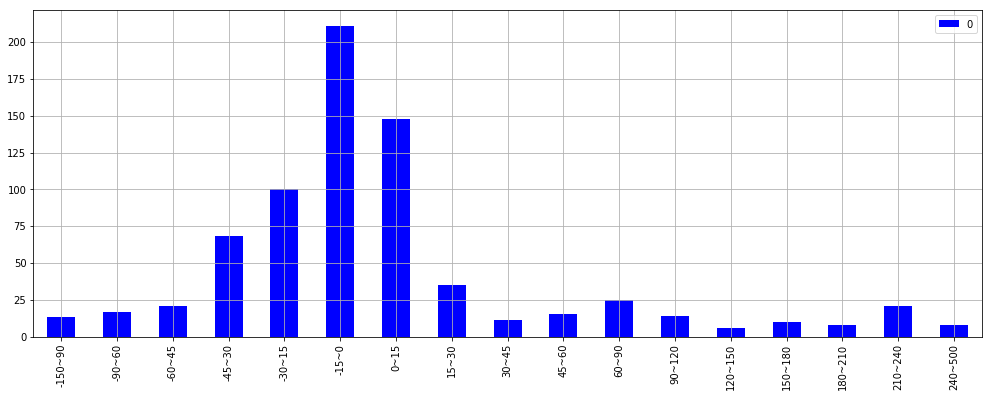

In [47]:
%pylab inline

import pandas as pd
import numpy as np

df = pd.read_excel('files/data.xlsx', sheetname=sheetName)

df['Date'] = df['成交時間'].dt.year.astype(str)+df['成交時間'].dt.month.astype(str)
df['Lot'] = df['口數']
df['Balance'] = df['平倉損益']

df = df[['Date','Lot','Balance']]

obj = {}
obj['-150~90'] = df[(df['Balance']/df['Lot'] >= -7500) & (df['Balance']/df['Lot'] < -4500)]['Lot'].sum()
obj['-90~60'] = df[(df['Balance']/df['Lot'] >= -4500) & (df['Balance']/df['Lot'] < -3000)]['Lot'].sum()
obj['-60~45'] = df[(df['Balance']/df['Lot'] >= -3000) & (df['Balance']/df['Lot'] < -2250)]['Lot'].sum()
obj['-45~30'] = df[(df['Balance']/df['Lot'] >= -2250) & (df['Balance']/df['Lot'] < -1500)]['Lot'].sum()
obj['-30~15'] = df[(df['Balance']/df['Lot'] >= -1500) & (df['Balance']/df['Lot'] < -750)]['Lot'].sum()
obj['-15~0'] = df[(df['Balance']/df['Lot'] >= -750) & (df['Balance']/df['Lot'] < 0)]['Lot'].sum()
obj['0~15'] = df[(df['Balance']/df['Lot'] >= 0) & (df['Balance']/df['Lot'] < 750)]['Lot'].sum()
obj['15~30'] = df[(df['Balance']/df['Lot'] >= 750) & (df['Balance']/df['Lot'] < 1500)]['Lot'].sum()
obj['30~45'] = df[(df['Balance']/df['Lot'] >= 1500) & (df['Balance']/df['Lot'] < 2250)]['Lot'].sum()
obj['45~60'] = df[(df['Balance']/df['Lot'] >= 2250) & (df['Balance']/df['Lot'] < 3000)]['Lot'].sum()
obj['60~90'] = df[(df['Balance']/df['Lot'] >= 3000) & (df['Balance']/df['Lot'] < 4500)]['Lot'].sum()
obj['90~120'] = df[(df['Balance']/df['Lot'] >= 4500) & (df['Balance']/df['Lot'] < 6000)]['Lot'].sum()
obj['120~150'] = df[(df['Balance']/df['Lot'] >= 6000) & (df['Balance']/df['Lot'] < 7500)]['Lot'].sum()
obj['150~180'] = df[(df['Balance']/df['Lot'] >= 7500) & (df['Balance']/df['Lot'] < 9000)]['Lot'].sum()
obj['180~210'] = df[(df['Balance']/df['Lot'] >= 9000) & (df['Balance']/df['Lot'] < 10500)]['Lot'].sum()
obj['210~240'] = df[(df['Balance']/df['Lot'] >= 10500) & (df['Balance']/df['Lot'] < 12000)]['Lot'].sum()
obj['240~500'] = df[(df['Balance']/df['Lot'] >= 12000) & (df['Balance']/df['Lot'] < 25000)]['Lot'].sum()

df = pd.DataFrame(obj, index=[0])
df = df[['-150~90','-90~60','-60~45','-45~30','-30~15','-15~0','0~15','15~30','30~45','45~60', \
         '60~90','90~120','120~150','150~180','180~210','210~240','240~500']]

df = pd.DataFrame(df.stack()[0])
df.plot(kind='bar', figsize=(17,6),color='Blue',grid=True) # DarkGreen, DarkOrange, DarkBlue, Gray

## 平倉損益淨利累積曲線圖

Populating the interactive namespace from numpy and matplotlib


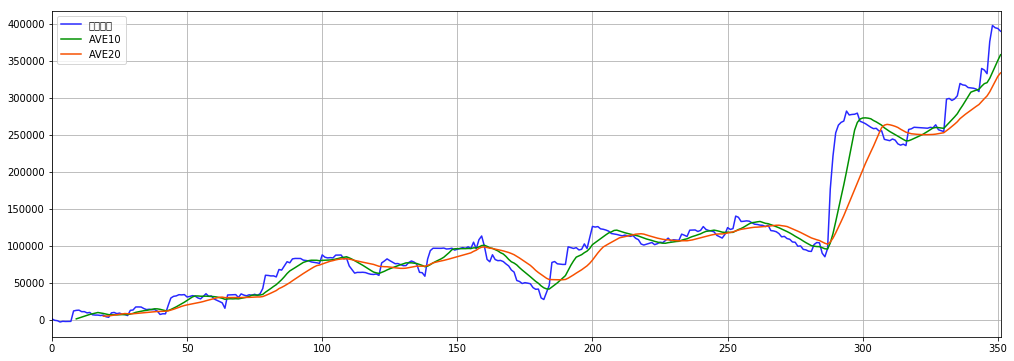

In [48]:
%pylab inline

import pandas as pd
import numpy as np

df = pd.read_excel('files/data.xlsx', sheetname=sheetName)
df = pd.DataFrame(df['平倉損益'].cumsum())

df['AVE10'] =  df['平倉損益'].rolling(window = 10).mean()
df['AVE20'] =  df['平倉損益'].rolling(window = 20).mean()
df
df.plot(linestyle='-',kind='line',figsize=(17,6),color=['#2828FF','#009100','#F75000'],grid=True) 

# End!!